## Intel Images classification problem

This notebook outlines steps to build a Convolutional Neural Network (CNN) model for image classification using Tensorflow and Keras. This notebook was created in Google Colab and is best run on a linux GPU-enabled node.

The image data used is the Intel Image Classification set from Kaggle: https://www.kaggle.com/puneet6060/intel-image-classification

This Data contains around 25k images of size 150x150 distributed under 6 categories:
- buildings: 0
- forest: 1
- glacier: 2
- mountain: 3
- sea: 4
- street: 5 

**Import libraries**

In [ ]:
import os
import shutil
import zipfile
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorboard.plugins.hparams import api as hp

### Download data from Kaggle

To download the dataset from Kaggle into your environment, you'll need to log in to kaggle and generate an API token (under your Account). Upload the *kaggle.json* file that was created to the same directory where your notebook is running. 

Then, follow the steps below to download the dataset used in this project.

For further info, see this blog:
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
# download data from kaggle
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download puneet6060/intel-image-classification

 96% 331M/346M [00:01<00:00, 172MB/s]
100% 346M/346M [00:02<00:00, 180MB/s]


In [ ]:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

### Organise data

The data is images held in folders according to classes. These are separated into training, testing and prediction data. Create variables for the file paths for each of training, testing and prediction directories.  

In [ ]:
# define main path where data will be held
data_dir = '/content'

# define paths for main train, test, prediction datasets
dir_train = os.path.join(data_dir,'seg_train','seg_train')
dir_test = os.path.join(data_dir,'seg_test','seg_test')
dir_pred = os.path.join(data_dir,'seg_pred','seg_pred')

**Copy some images for a smaller classification problem**

Move some files into a separate directory to reduce problem to simple binary classification as a learning exercise.

Copy a subset of the training (500 images) and validation data (50 images) into this directory. 

In [ ]:
# define paths for subsets of data
dir_train_sub = os.path.join(data_dir,'sub_train')
dir_test_sub = os.path.join(data_dir, 'sub_test')

# create subfolders for two classes
os.makedirs(os.path.join(data_dir,'sub_train/forest'))
os.makedirs(os.path.join(data_dir,'sub_test/forest'))
os.makedirs(os.path.join(data_dir,'sub_train/sea'))
os.makedirs(os.path.join(data_dir,'sub_test/sea'))

### move files 
# copy 500 files for each class for training, and 50 of each for validation (forest)
dir_train_forest = os.path.join(dir_train,'forest')
dir_train_sea = os.path.join(dir_train,'sea')

for idx, file in enumerate(os.listdir(dir_train_forest)[:550]):
    if idx < 500:
        shutil.copy(os.path.join(dir_train_forest,file),os.path.join(data_dir,'sub_train/forest'))
    else:
        shutil.copy(os.path.join(dir_train_forest,file),os.path.join(data_dir,'sub_test/forest'))

# copy 500 files for each class for training, and 50 of each for validation (sea)
for idx, file in enumerate(os.listdir(dir_train_sea)[:550]):
    if idx < 500:
        shutil.copy(os.path.join(dir_train_sea,file),os.path.join(data_dir,'sub_train/sea'))
    else:
        shutil.copy(os.path.join(dir_train_sea,file),os.path.join(data_dir,'sub_test/sea'))

**Generate a reference dataframe for the images**

In order to trial different models quickly, we may want to use a subset of the ~14000 images to train our model. This can be achieved by using the *ImageDataGenerator().flow_from_dataframe()* method, and passing a dataframe containing only the paths of images we wish to include in the subset. Let's start by training the model with only 1000 images.

We can simply pass the larger dataframe to the ImageDataGenerator if we wish to use all the images.

In [ ]:
### Training dataset
# use flow from dataframe to select only a subset of the values
images, labels = [], []
for sub_dir in os.listdir(dir_train):
    img_lst = os.listdir(os.path.join(dir_train,sub_dir))
    img_lst = list(map(lambda x:os.path.join(sub_dir,x),img_lst))
    images.extend(img_lst)
    labels.extend([sub_dir]*len(img_lst))
    
# create a dataframe of images and labels, shuffle it then create a subset (1000)
train_img_df = pd.DataFrame({"Images":images,"Labels":labels})      
train_img_df = train_img_df.sample(frac=1).reset_index(drop=True)
train_sub_img_df = train_img_df.copy().head(1000) 

# check balance of classes in the subset
train_sub_img_df.Labels.value_counts()

mountain     190
street       173
buildings    169
glacier      166
forest       163
sea          139
Name: Labels, dtype: int64

In [ ]:
### Validation dataset
# use flow from dataframe to select only a subset of the values
images, labels = [], []
for sub_dir in os.listdir(dir_test):
    img_lst = os.listdir(os.path.join(dir_test, sub_dir))
    img_lst = list(map(lambda x:os.path.join(sub_dir,x),img_lst))
    images.extend(img_lst)
    labels.extend([sub_dir]*len(img_lst))
    
# create a dataframe of images and labels, shuffle it then create a subset (600)
test_img_df = pd.DataFrame({"Images":images,"Labels":labels})      
test_img_df = test_img_df.sample(frac=1).reset_index(drop=True) 
test_sub_img_df = test_img_df.copy().head(600) 

# check balance of classes in the subset
test_sub_img_df.Labels.value_counts()

mountain     111
sea          105
glacier      103
street        97
forest        92
buildings     92
Name: Labels, dtype: int64

**Create training and validation data generators**

Use Keras's *ImageDataGenerator* and its *flow_from_dataframe()* method to generate batches of labelled data from the train and test data directories. Firstly, create generators for the smaller subset (binary task) of data.

In [ ]:
# normalize pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# point generator to training data directory and chosen 
train_generator_sub = train_datagen.flow_from_dataframe(
        dataframe=train_sub_img_df,
        directory=dir_train,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# point generator to test data
validation_generator_sub = test_datagen.flow_from_dataframe(
        dataframe=test_sub_img_df,
        directory=dir_test,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
print()
print(f"labels in the train generator are: {train_generator_sub.class_indices}")
print(f"labels in the validation generator are: {validation_generator_sub.class_indices}")
print()
data_imgs, labels = next(validation_generator_sub)
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

Found 1000 validated image filenames belonging to 6 classes.
Found 600 validated image filenames belonging to 6 classes.

labels in the train generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
labels in the validation generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32, 6)


In [ ]:
# normalize pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# point generator to training data directory and chosen 
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_img_df,
        directory=dir_train,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# point generator to test data
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_img_df,
        directory=dir_test,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
print()
print(f"labels in the train generator are: {train_generator.class_indices}")
print(f"labels in the validation generator are: {validation_generator.class_indices}")
print()
data_imgs, labels = next(validation_generator)
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.

labels in the train generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
labels in the validation generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32, 6)


### Model building and training

**Define model architectures**

Define a series of Convolutional Neural Network (CNN) architectures for our problem in the following functions. These will be trained and their accuracy score on the validation dataset will be compared.

In [ ]:
def simple_CNN():
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(6, activation='softmax')
  ])

  return model

In [ ]:
def complex_CNN():
  # define model architecture
  model = models.Sequential()
  model.add(layers.Conv2D(filters=64, kernel_size=(5,5), activation="relu", padding="same", input_shape=(150,150,3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128,activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64,activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32,activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(6, activation="softmax"))

  return model

In [ ]:
def lenet_5():
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(150,150,3)))
  model.add(layers.Conv2D(filters=6, kernel_size=(5,5), strides=1, activation="tanh"))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=16, kernel_size=(5,5), strides=1, activation="tanh"))
  model.add(layers.MaxPooling2D(pool_size=(5,5), strides=2))
  model.add(layers.Conv2D(filters=120, kernel_size=(5,5), strides=1, activation="tanh"))
  model.add(layers.Flatten())
  model.add(layers.Dense(84,activation="tanh"))
  model.add(layers.Dense(6, activation="softmax"))

  return model

In [ ]:
def alexnet():
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(150,150,3)))
  model.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=4, padding="valid",activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="valid"))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=1, padding="same",activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="valid"))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=1, padding="same",activation="relu"))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=1, padding="same",activation="relu"))
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same",activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="valid"))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096,activation="relu"))
  model.add(layers.Dense(4096,activation="relu"))
  model.add(layers.Dense(6, activation="softmax"))

  return model


In [ ]:
# using the ResNet50 model that comes as part of the Keras API and making some adjustments so it fits the use case
def resnet50():
  base_model = keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=(150,150,3), classes=6, classifier_activation='softmax')
  x = base_model.output
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(6, activation="softmax")(x)
  model = tf.keras.Model(base_model.input, x, name="model")
  return model

Define a function for model training that can be used for each of the different CNN architectures.

In [ ]:
# define a function for training the model
def train_model(model):

  # Compile the model
  model.compile(
    loss="categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
    )

  # train model
  history = model.fit(
    x=train_generator,
    epochs=30,
    batch_size=32,
    steps_per_epoch=64,
    validation_data=validation_generator,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
  
  return history

**Model training and evaluation**

For each of each of the model architectures defined above, train the model using the training data, capture the final validation set accuracy score and plot the learning model's for further evaluation.

Epoch 1/30
64/64 [==============================] - 9s 127ms/step - loss: 1.7726 - accuracy: 0.2012 - val_loss: 1.7506 - val_accuracy: 0.2543
Epoch 2/30
64/64 [==============================] - 8s 124ms/step - loss: 1.6858 - accuracy: 0.3335 - val_loss: 1.5607 - val_accuracy: 0.4410
Epoch 3/30
64/64 [==============================] - 8s 130ms/step - loss: 1.4842 - accuracy: 0.4243 - val_loss: 1.3491 - val_accuracy: 0.4943
Epoch 4/30
64/64 [==============================] - 8s 126ms/step - loss: 1.3787 - accuracy: 0.4572 - val_loss: 1.2874 - val_accuracy: 0.5070
Epoch 5/30
64/64 [==============================] - 8s 124ms/step - loss: 1.2672 - accuracy: 0.4946 - val_loss: 1.1863 - val_accuracy: 0.5413
Epoch 6/30
64/64 [==============================] - 9s 136ms/step - loss: 1.2048 - accuracy: 0.5332 - val_loss: 1.2081 - val_accuracy: 0.5223
Epoch 7/30
64/64 [==============================] - 8s 124ms/step - loss: 1.1679 - accuracy: 0.5298 - val_loss: 1.1487 - val_accuracy: 0.5523
Epoch 

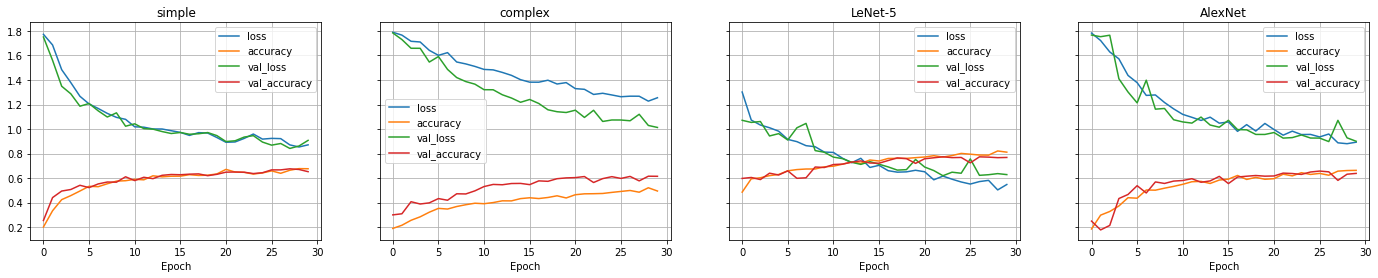

In [ ]:
# the history attribute is a dictionary providing scores for each epoch 
model_lst = ["simple","complex","LeNet-5","AlexNet"]
model_fns = [simple_CNN(), complex_CNN(), lenet_5(), alexnet()]

# you can plot these values, which includes accuracy on the training set and accuracy on the validation set
fig, ax = plt.subplots(1,4, sharey=True, figsize=(24,4))
epochs = list(range(30))

for i, model in enumerate(model_lst):

  clf = model_fns[i]
  history = train_model(clf)
  train_acc = history.history['accuracy'][-1]
  val_acc = history.history['val_accuracy'][-1]
  print(f"Model: {model_lst[i]}, Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

  ax[i].plot(epochs, history.history['loss'], label='loss')
  ax[i].plot(epochs, history.history['accuracy'], label='accuracy')
  ax[i].plot(epochs, history.history['val_loss'], label='val_loss')
  ax[i].plot(epochs, history.history['val_accuracy'], label='val_accuracy')
  ax[i].set_title(model_lst[i])
  ax[i].set_xlabel("Epoch")
  ax[i].grid(True)
  ax[i].legend();


Because the ResNet50 model was omitted from the above, it was trained as below.

In [ ]:
# Compile the model
history = train_model(model)

Epoch 1/30
64/64 [==============================] - 47s 642ms/step - loss: 23.1608 - accuracy: 0.2085 - val_loss: 1319.2100 - val_accuracy: 0.1323
Epoch 2/30
64/64 [==============================] - 38s 588ms/step - loss: 7.7925 - accuracy: 0.2808 - val_loss: 30.1863 - val_accuracy: 0.1673
Epoch 3/30
64/64 [==============================] - 37s 583ms/step - loss: 5.6081 - accuracy: 0.3784 - val_loss: 1.8758 - val_accuracy: 0.4123
Epoch 4/30
64/64 [==============================] - 37s 583ms/step - loss: 4.1043 - accuracy: 0.4331 - val_loss: 928.6902 - val_accuracy: 0.2403
Epoch 5/30
64/64 [==============================] - 37s 582ms/step - loss: 3.5782 - accuracy: 0.4678 - val_loss: 4.0526 - val_accuracy: 0.2800
Epoch 6/30
64/64 [==============================] - 37s 583ms/step - loss: 3.5154 - accuracy: 0.4526 - val_loss: 7.1812 - val_accuracy: 0.2520
Epoch 7/30
64/64 [==============================] - 37s 582ms/step - loss: 3.2263 - accuracy: 0.4873 - val_loss: 2.2169 - val_accuracy:

Model: ResNet50, Train accuracy: 0.7099609375, Validation accuracy: 0.7139999866485596


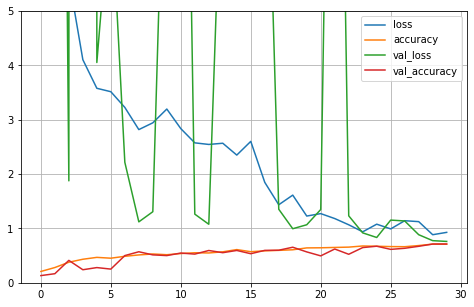

In [ ]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Model: ResNet50, Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

# visualise the model learning over the course of 30 epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-1]
plt.show();

### Model selection

The best performer was LeNet-5. However, ResNet50 looked to like it hadn't yet converged and so perhaps with more epochs, it would have yielded a higher accuracy score. This would need to be weighed up with its longer training duration and compute requirements than LeNet-5. 

Let's proceed using the lenet-5 model and analyse it's results.

In [ ]:
# retrain the LeNet-5 model
LeNet5 = lenet_5()
LeNet5.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(x=train_generator, epochs=30, batch_size=32, steps_per_epoch=64, validation_data=validation_generator)

Epoch 1/30
64/64 [==============================] - 38s 588ms/step - loss: 0.8202 - accuracy: 0.7271 - val_loss: 0.7583 - val_accuracy: 0.7127
Epoch 2/30
64/64 [==============================] - 38s 595ms/step - loss: 1.1096 - accuracy: 0.7061 - val_loss: 0.9695 - val_accuracy: 0.6890
Epoch 3/30
64/64 [==============================] - 37s 582ms/step - loss: 1.1804 - accuracy: 0.7021 - val_loss: 0.9426 - val_accuracy: 0.6723
Epoch 4/30
64/64 [==============================] - 37s 588ms/step - loss: 0.9173 - accuracy: 0.7368 - val_loss: 0.7742 - val_accuracy: 0.7130
Epoch 5/30
64/64 [==============================] - 38s 593ms/step - loss: 0.9112 - accuracy: 0.7070 - val_loss: 0.7082 - val_accuracy: 0.7377
Epoch 6/30
64/64 [==============================] - 38s 595ms/step - loss: 0.8918 - accuracy: 0.7324 - val_loss: 0.7646 - val_accuracy: 0.7343
Epoch 7/30
64/64 [==============================] - 37s 587ms/step - loss: 0.8826 - accuracy: 0.7311 - val_loss: 1.0199 - val_accuracy: 0.6427

Model: LeNet-5, Train accuracy: 0.74853515625, Validation accuracy: 0.7099999785423279


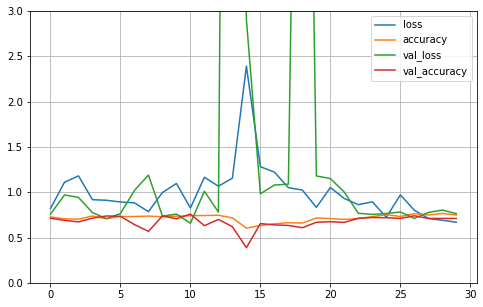

In [ ]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Model: LeNet-5, Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

# visualise the model learning over the course of 30 epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-1]
plt.show();

### Results analysis

Run the trained LeNet-5 model on the entire test dataset to generate predictions. This will enable a deeper-dive investigation into how the model was performing. 

First, create a new generator that will generate all the test images in a single batch. Then retrieve the class labels for the predictions and targets, and produce a confusion matrix to see which classes the model correctly classified and those it didn't. Finally, save the model for later use.

In [ ]:
# generate test data for predictions
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_img_df,
        directory=dir_test,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=3000,
        class_mode='categorical')
X_test, y_test = next(test_generator)

Found 3000 validated image filenames belonging to 6 classes.


In [ ]:
# generate predictions and view results across all classes
y_pred = model.predict(x=X_test)

y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)

In [ ]:
# generate results table
classes = ["buildings","forest","glacier","mountain","sea","street"]

accs = confusion_matrix(y_test_classes, y_pred_classes)
results = pd.DataFrame(accs, columns=[["Predicted"]*6,classes], index=[["Actual"]*6,classes])
results["Accuracy"] = accs.diagonal() / accs.sum(axis=1)
print(results)

                 Predicted                                      Accuracy
                 buildings forest glacier mountain  sea street          
Actual buildings       210     21       8       55   30    113  0.480549
       forest            5    432       2        6    1     28  0.911392
       glacier           1      5     278       87  172     10  0.502712
       mountain          4      1      31      395   90      4  0.752381
       sea               9     10      24       68  390      9  0.764706
       street           24     31       5        5   11    425  0.848303


In [ ]:
# save the model
LeNet5.save("LeNet-5.h5")